# Proyecto 1 - Procesamiento Adaptativo de Señales
# Detección de arritmias

In [390]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import wfdb

## Real-time Peak Detector class

In [391]:
import numpy as np

class real_time_peak_detector():
    def __init__(self, array, width, threshold):
        """
        Parameters
        ----------
        array
            List or np.array of the first 'width' values in input signal.
        width
            A peak with index [i] will only be detected if it is the maximum value amongst the samples [i-width : i+width]
        threshold
            Minimum amplitude to be considered for peak detection
        """
        self.values = list(array)
        self.width = width
        self.threshold = threshold
        self.max_value = max(self.values)
        self.max_index = self.values.index(self.max_value)
        self.pslope = False

    def set_new_value(self, new_value):
        """
        Set new signal value and return whether there was a peak in the signal.
        
        Parameters
        ----------
        new_value
            New value in input signal.
        Returns
        -------
        bool
            True if there was a peak with index [i - peak_width + 1] relative to current sample index, False otherwise.
        """
        self.pslope = (self.values[1] > self.values[0])
        self.values = self.values[1:] + [new_value]
 
        if new_value > self.max_value:
            self.max_value = new_value
            self.max_index = self.width-1
        else:
            self.max_index -= 1

        if self.max_index == 0 and self.max_value > self.threshold and self.pslope:
            # Reset max values
            self.max_value = new_value
            self.max_index = self.width-1
            return True
        else:
            return False

# Importar datos del ECG para el paciente '100'

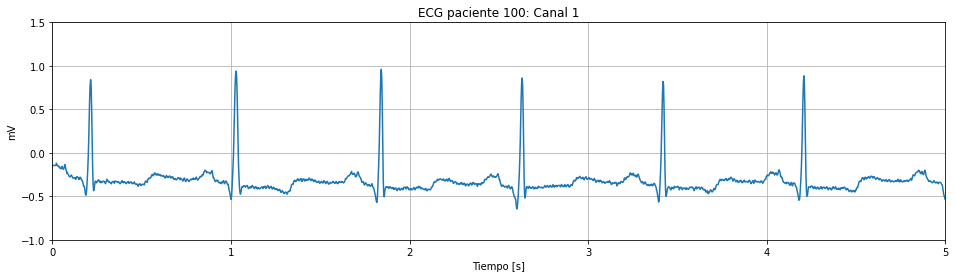

In [392]:
N = 600000

record, record_data = wfdb.rdsamp('mit-bih-arrhythmia-database-1.0.0/100', sampto=N)
annotation = wfdb.rdann('mit-bih-arrhythmia-database-1.0.0/100', 'atr', sampto=N)

fs = record_data['fs']
channel1 = record[:,0].reshape((N, 1))
time = np.arange(0, len(channel1)/fs, 1/fs)

plt.figure(figsize=(16, 4))
plt.plot(time, channel1)
plt.xlabel('Tiempo [s]')
plt.ylabel(record_data['units'][0])
plt.xlim(0, 5)
plt.ylim(-1, 1.5)
plt.title('ECG paciente 100: Canal 1')
plt.grid()
plt.show()

# FIR: Baseline wander removal

In [393]:
# FIR filtering
M = 256
w = np.ones((M, 1)) / M
e = np.zeros((N, 1))
yhat = np.ones((N, 1)) * np.mean(channel1[ : M])

for i in range(M, N):
    x = channel1[i-M : i]
    y = channel1[i]

    yhat[i] = (w.T @ x).item(0)
    e[i] = y - yhat[i]

channel1_a = e

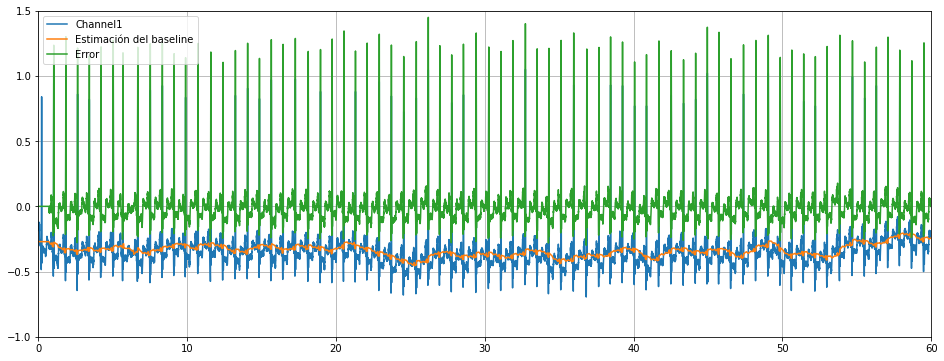

In [394]:
plt.figure(figsize=(16, 6))
plt.plot(time, channel1, label = 'Channel1')
plt.plot(time, yhat, label = 'Estimación del baseline')
plt.plot(time, e, label = 'Error')
plt.xlim(0, 60)
plt.ylim(-1, 1.5)
plt.grid()
plt.legend(loc='upper left')
plt.show()

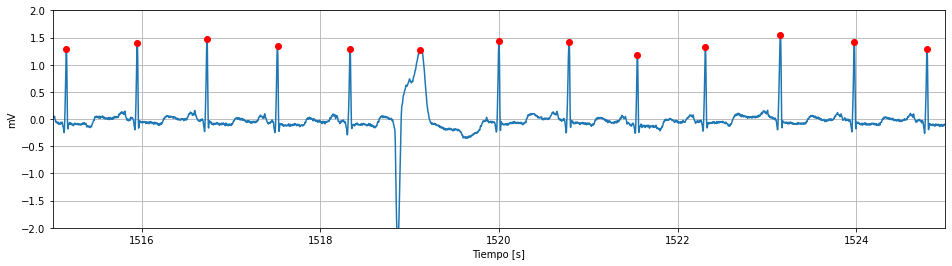

In [395]:
peak_width = 32
peak_detector = real_time_peak_detector(channel1_a[:peak_width], peak_width, 0.7)

peaks = []
peaks_time_index = []

for i in range(peak_width, len(channel1_a.flatten())):
    if peak_detector.set_new_value(channel1_a[i]) > 0:
        peaks.append(i - peak_width + 1)

plt.figure(figsize=(16, 4))
plt.plot(time, channel1_a)
plt.plot(time[peaks], channel1_a[peaks], 'ro')

plt.xlabel('Tiempo [s]')
plt.ylabel(record_data['units'][0])
plt.xlim(1515, 1525)
plt.ylim(-2, 2)
plt.grid()
plt.show()

# LMS: RR Intervals signal

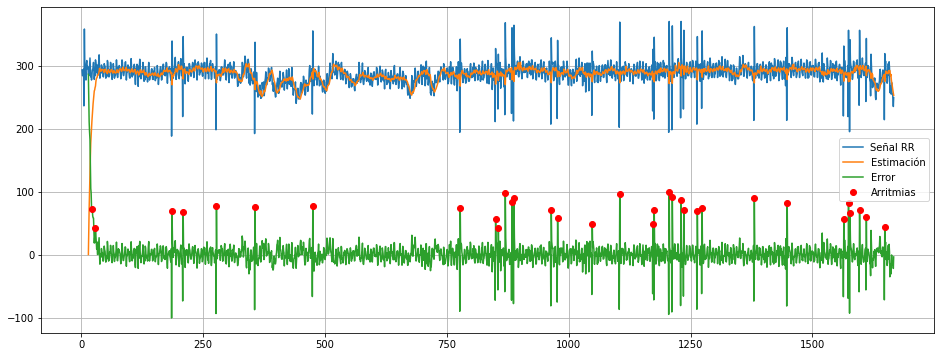

In [396]:
# LMS
M = 16
w = np.zeros((M, 1))    # el vector queda en el orden inverso al tradicional
e = []
yhat = []
mu = 1e-7

offset = 0

peak_width = 30
peak_detector = real_time_peak_detector(channel1_a[ : peak_width], peak_width, 0.7)

peaks = np.array([])
RR = np.array([])
time_indexes = np.array([])

for i in range(peak_width, N):
    if peak_detector.set_new_value(channel1_a[i]):
        peaks = np.append(peaks, i - peak_width + 1)
        if len(peaks)>1:
            RR = np.append(RR, peaks[-1] - peaks[-2])
            time_indexes = np.append(time_indexes, i/fs)

            if len(RR) > M:
                x = RR[-M-1 : -1].reshape((M, 1))
                y = RR[-1]

                yhat.append( (w.T @ x).item(0) )
                e.append( y - yhat[-1] )
                w = np.add(w, mu * e[-1] * x)

peaks, _ = signal.find_peaks(e, height=40)

plt.figure(figsize=(16, 6))
plt.plot(time_indexes, RR, label = 'Señal RR')
plt.plot(time_indexes[M:], yhat, label = 'Estimación')
plt.plot(time_indexes[M:], e, label = 'Error')
plt.plot([time_indexes[p+M] for p in peaks], [e[p] for p in peaks], 'ro', label = 'Arritmias')
plt.grid()
plt.legend()
plt.show()

# LMS: Morfología usando señal de deltas

In [397]:
M = 128
w = np.zeros((M, 1))    # el vector queda en el orden inverso al tradicional
e = np.zeros(N)
yhat = np.zeros(N)
x = np.zeros((M, 1))
mu = 1e-1

peak_width = 32
peak_detector = real_time_peak_detector(channel1_a[ : peak_width], peak_width, threshold=0.7)

delay = peak_width + 32     # +32 para darle un poco de margen de seguridad

for i in range(peak_width, N):
    if peak_detector.set_new_value(channel1_a[i]):    # Hay un nuevo pico en [i - peak_width + 1] ?
        x = np.zeros((M, 1))
        x[-1] = 1
    else:
        x = np.roll(x, -1)
        x[-1] = 0

    y = channel1_a[i - delay]
    yhat[i - delay] = (w.T @ x).item(0)
    e[i - delay] = y - yhat[i - delay]
    w = np.add(w, mu * e[i - delay] * x)

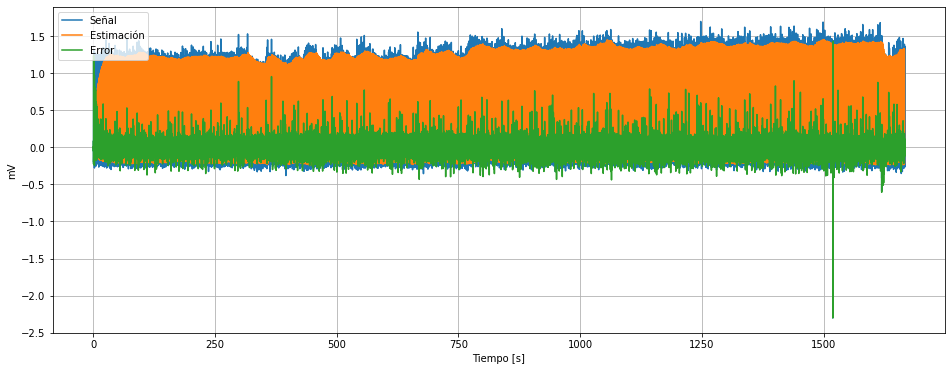

In [398]:
plt.figure(figsize=(16, 6))
plt.plot(time, channel1_a, label = 'Señal')
plt.plot(time, yhat, label = 'Estimación')
plt.plot(time, e, label = 'Error')
plt.xlabel('Tiempo [s]')
plt.ylabel(record_data['units'][0])

#plt.xlim(1517, 1520)
plt.grid()
plt.legend(loc='upper left')
plt.show()

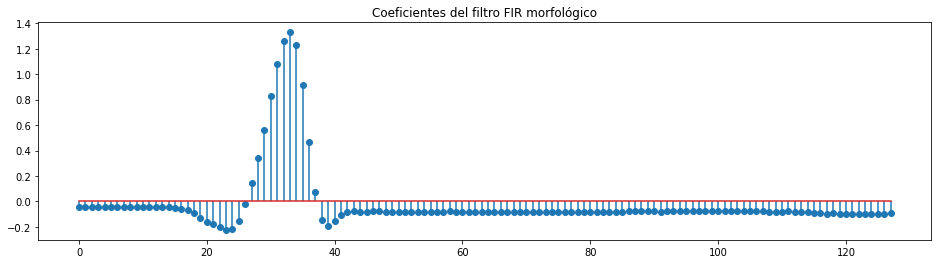

In [399]:
plt.figure(figsize=(16, 4))
plt.stem(np.flip(w))
file = open('w.txt', 'w')
for i in w:
    file.write(f'{i[0]}\n')
file.close()
plt.title('Coeficientes del filtro FIR morfológico')
plt.show()

# Integración del sistema completo

In [400]:
# Peak detector
peak_width = 32
peak_threshold = 0.7
peak_detector = real_time_peak_detector(channel1[ : peak_width], peak_width, peak_threshold)

# FIR: Baseline Wander Removal
M_wander = 256
w_wander = np.ones((M_wander, 1)) / M_wander    # el vector queda en el orden inverso al tradicional
e_wander = np.zeros((N, 1))
yhat_wander = np.ones((N, 1)) * np.mean(channel1[ : M_wander])
mu_wander = 5e-6

# LMS: RR Interval Arrhythmias
M_rr = 16
w_rr = np.zeros((M_rr, 1))    # el vector queda en el orden inverso al tradicional
e_rr = []
yhat_rr = []
mu_rr = 1e-7

peaks = np.array([])
RR = np.array([])
RR_time_indexes = np.array([])

# LMS: Morphological Arrhythmias
M_morph = 128
w_morph = np.zeros((M_morph, 1))    # el vector queda en el orden inverso al tradicional
e_morph = np.zeros(N)
yhat_morph = np.zeros(N)
x_morph = np.zeros((M_morph, 1))
mu_morph = 1e-1

# Delay en el path de la señal deseada
# # +32 para darle un poco de margen de seguridad
delay_morph = peak_width + 32

#Init w_morph
file = open('w.txt')
for i,line in enumerate(file.readlines()):
    w_morph[i] = float(line.rstrip('\n'))
file.close()

for i in range(M_wander, N):
    # Wander
    x_wander = channel1[i-M_wander : i]
    y_wander = channel1[i]
    yhat_wander[i] = (w_wander.T @ x_wander).item(0)
    e_wander[i] = y_wander - yhat_wander[i]
    #w_wander = np.add(w_wander, mu_wander * e_wander[i] * x_wander)

    # Arrhythmia Detection
    if peak_detector.set_new_value(e_wander[i]):
        peaks = np.append(peaks, i - peak_width + 1)    # Hay un nuevo pico en [i - peak_width + 1] ?
        if len(peaks)>1:
            RR = np.append(RR, peaks[-1] - peaks[-2])
            RR_time_indexes = np.append(RR_time_indexes, i/fs)

            if len(RR) > M_rr:
                x_rr = RR[-M_rr-1 : -1].reshape((M_rr, 1))
                y_rr = RR[-1]

                yhat_rr.append( (w_rr.T @ x_rr).item(0) )
                e_rr.append( y_rr - yhat_rr[-1] )
                w_rr = np.add(w_rr, mu_rr * e_rr[-1] * x_rr)

        x_morph = np.zeros((M_morph, 1))
        x_morph[-1] = 1

    else:
        x_morph = np.roll(x_morph, -1)
        x_morph[-1] = 0

    y_morph = e_wander[i - delay_morph]
    yhat_morph[i - delay_morph] = (w_morph.T @ x_morph).item(0)
    e_morph[i - delay_morph] = y_morph - yhat_morph[i - delay_morph]
    w_morph = np.add(w_morph, mu_morph * e_morph[i - delay_morph] * x_morph)

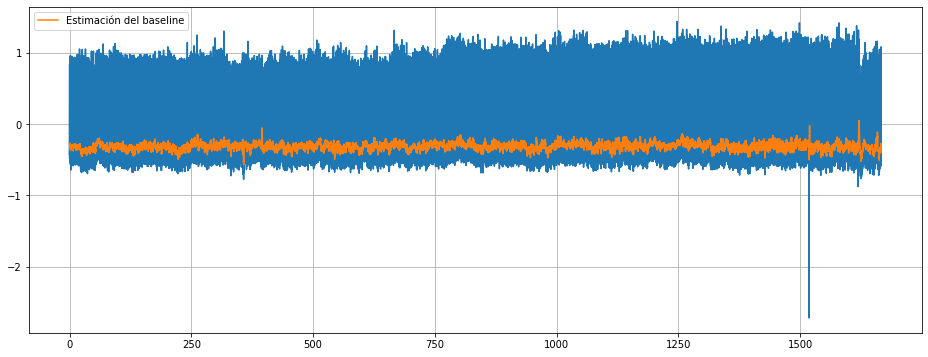

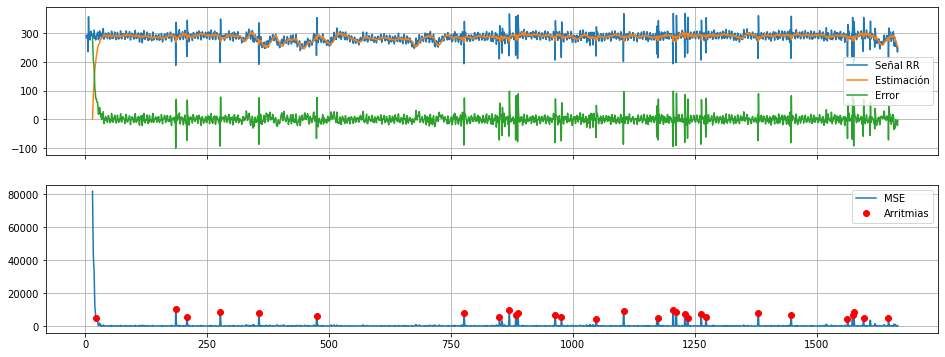

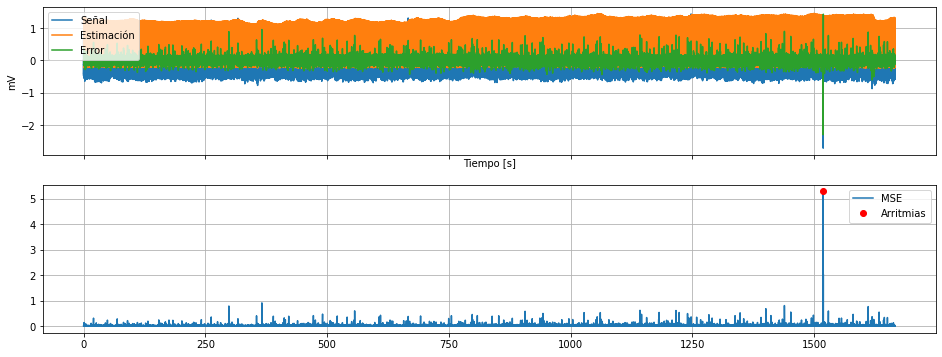

In [401]:
MSE_rr = np.array(e_rr)**2
MSE_morph = np.array(e_morph)**2

peaks_rr, _ = signal.find_peaks(MSE_rr, height=4000)
peaks_morph, _ = signal.find_peaks(MSE_morph, height=1, distance=180)

plt.figure(figsize=(16, 6))
plt.plot(time, channel1)
plt.plot(time, yhat_wander, label = 'Estimación del baseline')
plt.grid()
plt.legend()
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 6), sharex=True)
ax1.plot(RR_time_indexes, RR, label = 'Señal RR')
ax1.plot(RR_time_indexes[M_rr:], yhat_rr, label = 'Estimación')
ax1.plot(RR_time_indexes[M_rr:], e_rr, label = 'Error')
ax1.grid()
ax1.legend()
ax2.plot(RR_time_indexes[M_rr:], MSE_rr, label = 'MSE')
ax2.plot([RR_time_indexes[p+M_rr] for p in peaks_rr], [MSE_rr[p] for p in peaks_rr], 'ro', label = 'Arritmias')
ax2.grid()
ax2.legend()
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 6), sharex=True)
ax1.plot(time, channel1, label = 'Señal')
ax1.plot(time, yhat_morph, label = 'Estimación')
ax1.plot(time, e_morph, label = 'Error')
ax1.set_xlabel('Tiempo [s]')
ax1.set_ylabel(record_data['units'][0])
ax1.grid()
ax1.legend(loc='upper left')
ax2.plot(time, MSE_morph, label = 'MSE')
ax2.plot([time[p] for p in peaks_morph], [MSE_morph[p] for p in peaks_morph], 'ro', label = 'Arritmias')
ax2.grid()
ax2.legend()
plt.show()

# Verificación de Resultados

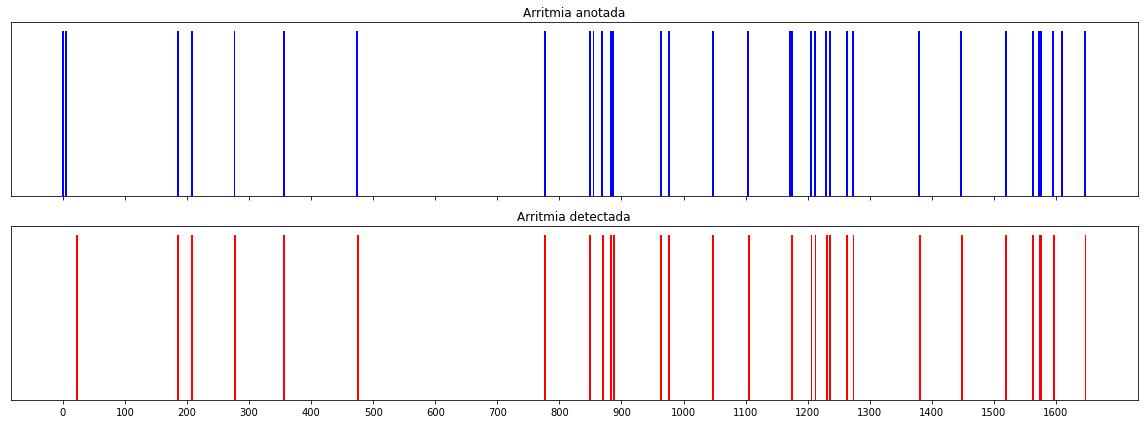

In [402]:
ann_times = []
ann_values = []

for sample, symbol in zip(annotation.sample, annotation.symbol):
    if symbol != 'N':
        ann_times.append(time[sample])
        ann_values.append(1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 6), sharex=True)
ax1.bar(ann_times, ann_values, width=3, color='b')
ax1.get_yaxis().set_visible(False)
ax1.set_title('Arritmia anotada')

ax2.bar([RR_time_indexes[p+M_rr] for p in peaks_rr], [1 for p in peaks_rr], width=3, color='r')
ax2.bar([time[p] for p in peaks_morph], [1 for p in peaks_morph], width=3, color='r')
ax2.set_xticks(np.arange(0, N/fs, 100))
ax2.get_yaxis().set_visible(False)
ax2.set_title('Arritmia detectada')

plt.tight_layout()
plt.savefig('Resultados Proyecto 1.png', dpi=300)
#plt.xlim(100, 500)
plt.show()

# Análisis de los Resultados

In [403]:
ann_times = np.around(np.array(ann_times), decimals=2)
rr_times = [RR_time_indexes[p+M_rr] for p in peaks_rr]
morph_times = [time[p] for p in peaks_morph]
det_times = np.around(np.sort(np.concatenate((rr_times, morph_times))), decimals=2)

tolerance = 1.15        # tolerancia en segundos para comparar picos anotados y detectados

true_positive = np.array([x for x in det_times for y in ann_times if np.isclose(x, y, atol=tolerance)])
false_positive = det_times[~np.isin(det_times,true_positive)]
false_negative = ann_times[~np.isin(ann_times,np.array([x for x in ann_times for y in det_times if np.isclose(x, y, atol=tolerance)]))]

#np.set_printoptions(suppress=True)
#print(true_positive)
#print(false_positive)
#print(false_negative)

sensitivity = len(true_positive) / (len(true_positive) + len(false_negative)) * 100     # True Positive Rate (Sensitivity)
miss_rate = len(false_negative) / (len(false_negative) + len(true_positive)) * 100      # False Negative Rate (Miss Rate)
precision = len(true_positive) / (len(true_positive) + len(false_positive)) * 100       # Precision

print(sensitivity)
print(miss_rate)
print(precision)

85.29411764705883
14.705882352941178
96.66666666666667
